# Tensorflow
# CIFAR-10
by <a>Vitmar Aliaga</a>, <a>Maria Salazar</a> /<a>GitHub</a>/ <a>Videos en YouTube</a>
## Introducción
Este tutorial muestra cómo hacer una red neuronal convolucional para clasificar imágenes en el conjunto de datos CIFAR-10. También muestra cómo usar diferentes redes durante el entrenamiento y la prueba.

Esto se basa en los tutoriales anteriores, por lo que debe tener una comprensión básica de TensorFlow y el paquete complementario Pretty Tensor. Una gran parte del código fuente y  el texto en este tutorial es similar a los tutoriales anteriores y puede leerse rápidamente si ha leído recientemente los tutoriales anteriores.

## Diagrama de flujo
El siguiente cuadro muestra aproximadamente cómo fluyen los datos en la red neuronal convolucional que se implementa a continuación. Primero, la red tiene una capa de procesamiento previo que distorsiona las imágenes de entrada para inflar artificialmente el conjunto de entrenamiento.Entonces la red tiene dos capas convolucionales, dos capas completamente conectadas y finalmente una capa de clasificación de softmax.Los pesos y las salidas de las capas convolucionales se muestran con más detalle en las gráficas más grandes que se encuentran más abajo, y el Tutorial n.º 02 entra en más detalles sobre cómo funciona la convolución.

En este caso, la imagen está mal clasificada. La imagen en realidad muestra un perro, pero la red neuronal se confunde ya sea un perro o un gato y cree que la imagen es más probable que sea un gato.

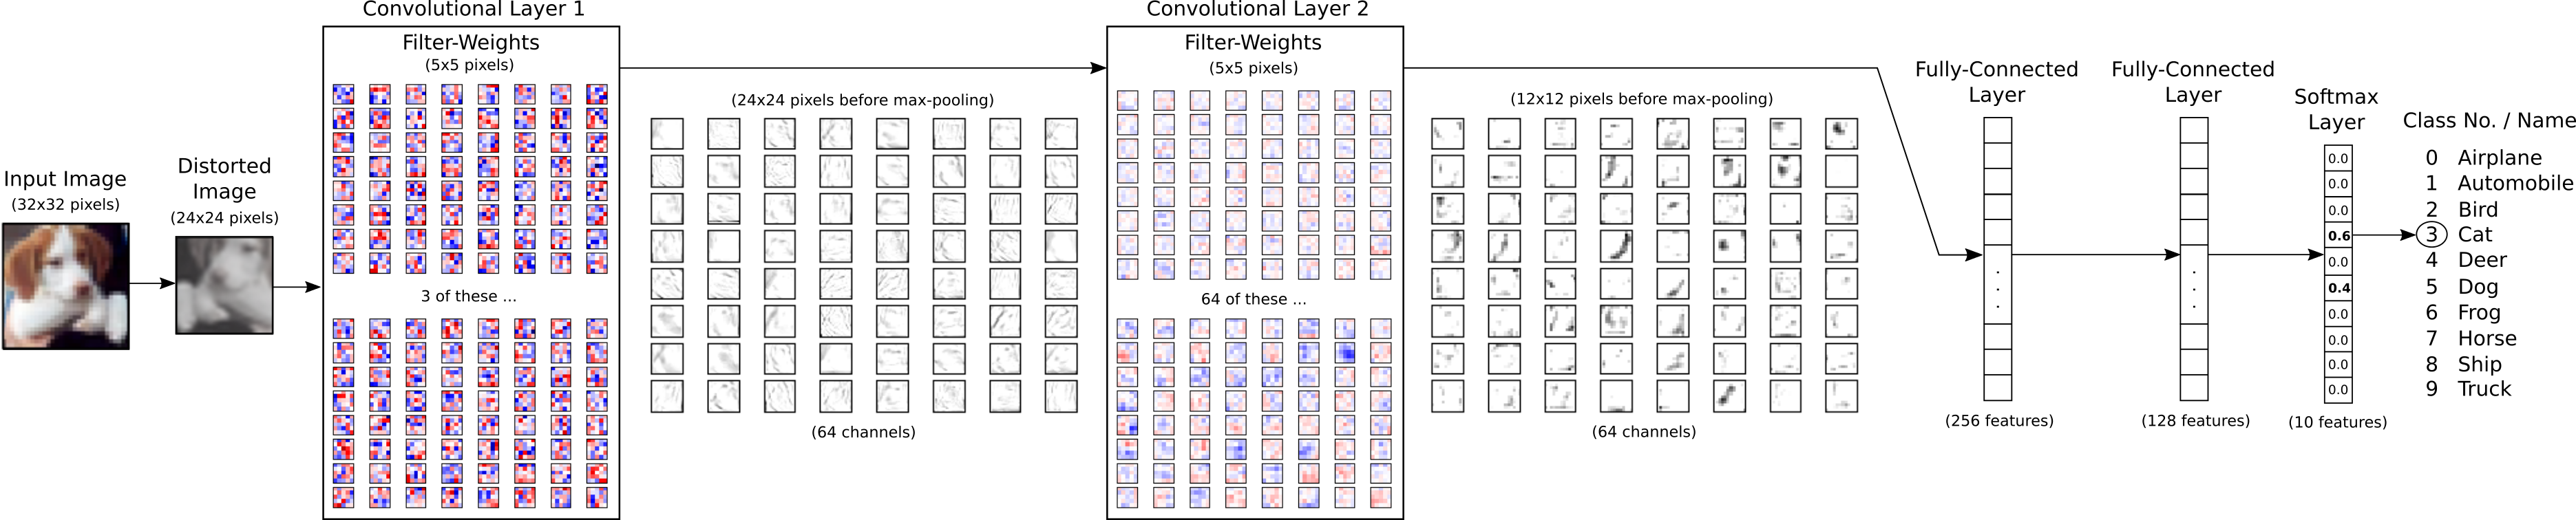

In [1]:
from IPython.display import Image
Image('images/06_network_flowchart.png')

## Importaciones

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math, os

# Utilice PrettyTensor para simplificar la construcción de redes neuronales.
import prettytensor as pt

Esto fue desarrollado usando Python 3.5.2 (Anaconda) y la versión de TensorFlow:

In [3]:
tf.__version__

'1.3.0'

PrettyTensor version:

In [4]:
pt.__version__

'0.7.4'

## Load Data

In [5]:
import cifar10

Establezca la ruta para almacenar el conjunto de datos en su computadora.

In [6]:
# cifar10.data_path = "data/CIFAR-10/"

El conjunto de datos CIFAR-10 tiene unos 163 MB y se descargará automáticamente si no se encuentra en la ruta determinada.

In [7]:
cifar10.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.


Cargue los nombres de clase.

In [8]:
class_names = cifar10.load_class_names()
class_names

Loading data: data/CIFAR-10/cifar-10-batches-py/batches.meta


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Cargue el conjunto de entrenamiento. Esto devuelve las imágenes, los números de clase como números enteros y los números de clase como matrices codificadas One-Hot denominadas etiquetas.

In [9]:
images_train, cls_train, labels_train = cifar10.load_training_data()

Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5


Cargue el conjunto de prueba.

In [10]:
images_test, cls_test, labels_test = cifar10.load_test_data()

Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch


El conjunto de datos CIFAR-10 ahora se ha cargado y consta de 60,000 imágenes y etiquetas asociadas (es decir, clasificaciones de las imágenes). El conjunto de datos se divide en 2 subconjuntos mutuamente excluyentes, el conjunto de entrenamiento y el conjunto de prueba.

In [11]:
print("Tamaño de:")
print("- Conjunto de entrenamiento:\t\t{}".format(len(images_train)))
print("- Conjunto de prueva:\t\t{}".format(len(images_test)))

Tamaño de:
- Conjunto de entrenamiento:		50000
- Conjunto de prueva:		10000


## Dimensiones de datos

Las dimensiones de datos se usan en varios lugares en el código fuente a continuación. Ya se han definido en el módulo cifar10, por lo que solo debemos importarlos.

In [12]:
from cifar10 import img_size, num_channels, num_classes

Las imágenes tienen 32 x 32 píxeles, pero recortamos las imágenes a 24 x 24 píxeles.

In [13]:
img_size_cropped = 24

## Función auxiliar para trazar imágenes

Función utilizada para trazar 9 imágenes en una cuadrícula de 3x3, y escribir las clases verdadera y predicha debajo de cada imagen.

In [14]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true) == 9

    # Crear figura con sub-parcelas.
    fig, axes = plt.subplots(3, 3)

    # Ajusta el espaciado vertical si necesitamos imprimir el conjunto y la mejor red.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Tipo de interpolación
        if smooth:
            interpolation = 'spline16'
        else:
            interpolation = 'nearest'

        # Trazar imagen.
        ax.imshow(images[i, :, :, :],
                  interpolation=interpolation)
            
        # Nombre de la clase verdadera.
        cls_true_name = class_names[cls_true[i]]

        # Mostrar clases verdaderas y predichas.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true_name)
        else:
            # Nombre de la clase predicha.
            cls_pred_name = class_names[cls_pred[i]]

            xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

        # Muestra las clases como la etiqueta en el eje x.
        ax.set_xlabel(xlabel)
        
        # Eliminar garrapatas de la trama.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Asegúrese de que la trama se muestra correctamente con múltiples parcelas
    # en una sola celda de Notebook.
    plt.show()

## Trace algunas imágenes para ver si los datos son correctos

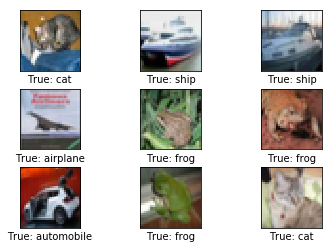

In [15]:
# Obtenga las primeras imágenes del conjunto de prueba.
images = images_test[0:9]

# Obtenga las verdaderas clases para esas imágenes.
cls_true = cls_test[0:9]

# Grafica las imágenes y las etiquetas usando nuestra función auxiliar arriba.
plot_images(images=images, cls_true=cls_true, smooth=False)

Las imágenes pixeladas de arriba son lo que la red neuronal obtendrá como entrada. Las imágenes pueden ser un poco más fáciles de reconocer para el ojo humano si suavizamos los píxeles.

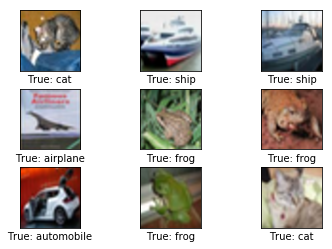

In [16]:
plot_images(images=images, cls_true=cls_true, smooth=True)

## Gráfico TensorFlow

Todo el propósito de TensorFlow es tener un llamado gráfico computacional que se puede ejecutar de manera mucho más eficiente que si los mismos cálculos se realizaran directamente en Python.TensorFlow puede ser más eficiente que NumPy porque TensorFlow conoce todo el gráfico de computación que debe ejecutarse, mientras que NumPy solo conoce el cálculo de una operación matemática individual a la vez.

TensorFlow también puede calcular automáticamente los degradados que se necesitan para optimizar las variables del gráfico a fin de que el modelo tenga un mejor rendimiento.Esto se debe a que el gráfico es una combinación de expresiones matemáticas simples, por lo que el gradiente de todo el gráfico puede calcularse utilizando la regla de cadena para derivadas.

TensorFlow también puede aprovechar las CPU multinúcleo y las GPU, y Google incluso ha creado chips especiales solo para TensorFlow que se denominan TPU (unidades de procesamiento Tensor) y son incluso más rápidos que las GPU.

Un gráfico de TensorFlow consta de las siguientes partes que se detallarán a continuación:

* Variables de marcador de posición usadas para ingresar datos al gráfico.
* Variables que se optimizarán para que la red convolucional tenga un mejor rendimiento.
* Las fórmulas matemáticas para la red convolucional.
* Una medida de pérdida que se puede usar para guiar la optimización de las variables.
* Un método de optimización que actualiza las variables.

Además, el gráfico TensorFlow también puede contener varias declaraciones de depuración, p. para que los datos de registro se muestren usando TensorBoard, que no está cubierto en este tutorial.

## Variables de marcador de posición
Las variables de marcador de posición sirven como la entrada al gráfico computacional de TensorFlow que podemos cambiar cada vez que ejecutamos el gráfico. Llamamos a esto alimentar las variables de marcador de posición y se demuestra más adelante.

Primero definimos la variable marcador de posición para las imágenes de entrada. Esto nos permite cambiar las imágenes que se ingresan al gráfico TensorFlow. Este es un llamado tensor, lo que significa que es una matriz multidimensional. [None, img_size, img_size, num_channels], donde Ninguno significa que el tensor puede contener un número arbitrario de imágenes con cada img_size pixels high e img_size pixels wide y con num_channels channels channel.

In [17]:
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, num_channels], name='x')

A continuación tenemos la variable de marcador de posición para las etiquetas verdaderas asociadas con las imágenes que se ingresaron en la variable de marcador de posición x. La forma de esta variable de marcador de posición es [None, num_clases] lo que significa que puede contener un número arbitrario de etiquetas y cada etiqueta es un vector de longitud num_clases que es 10 en este caso.

In [18]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

También podríamos tener una variable de marcador de posición para el número de clase, pero en cambio la calcularemos usando argmax. Tenga en cuenta que este es un operador TensorFlow, por lo que no se calcula nada en este punto.

In [19]:
y_true_cls = tf.argmax(y_true, axis=1)

## Función auxiliar para crear preprocesamiento

Las siguientes funciones auxiliares crean la parte del gráfico computacional TensorFlow que preprocesa las imágenes de entrada. Nada se calcula realmente en este punto, la función simplemente agrega nodos al gráfico computacional para TensorFlow.

El preprocesamiento es diferente para el entrenamiento y la prueba de la red neuronal:

* Para el entrenamiento, las imágenes de entrada se recortan al azar, se voltean aleatoriamente horizontalmente y el tono, el contraste y la saturación se ajustan con valores aleatorios. Esto infla artificialmente el tamaño del conjunto de entrenamiento al crear variaciones aleatorias de las imágenes de entrada originales. Ejemplos de imágenes distorsionadas se muestran más abajo.
* Para la prueba, las imágenes de entrada se recortan alrededor del centro y no se ajusta nada más.

In [20]:
def pre_process_image(image, training):
    # Esta función toma una sola imagen como entrada,
    # y un booleano para construir el gráfico de entrenamiento o prueba.
    
    if training:
        # Para el entrenamiento, agregue lo siguiente al gráfico TensorFlow.

        # Recortar al azar la imagen de entrada.
        image = tf.random_crop(image, size=[img_size_cropped, img_size_cropped, num_channels])

        # Aleatoriamente voltee la imagen horizontalmente.
        image = tf.image.random_flip_left_right(image)
        
        # Ajusta aleatoriamente el tono, el contraste y la saturación.
        image = tf.image.random_hue(image, max_delta=0.05)
        image = tf.image.random_contrast(image, lower=0.3, upper=1.0)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_saturation(image, lower=0.0, upper=2.0)

        # Algunas de estas funciones pueden desbordarse y dar como resultado píxeles 
        # valores más allá del rango [0, 1]. No está claro desde el
        # documentación de TensorFlow 0.10.0rc0 si esto es
        # destinado a. Una solución simple es limitar el rango.

        # Limite los píxeles de la imagen entre [0, 1] en caso de desbordamiento.
        image = tf.minimum(image, 1.0)
        image = tf.maximum(image, 0.0)
    else:
        # Para el entrenamiento, agregue lo siguiente al gráfico TensorFlow.

        # Recorta la imagen de entrada alrededor del centro para que sea la misma  
        # tamaño como imágenes que se recortan al azar durante el entrenamiento.
        image = tf.image.resize_image_with_crop_or_pad(image,
                                                       target_height=img_size_cropped,
                                                       target_width=img_size_cropped)

    return image

La función anterior se llama para cada imagen en el lote de entrada usando la siguiente función.

In [21]:
def pre_process(images, training):
    # Utilice TensorFlow para recorrer todas las imágenes de entrada y llamar
    # la función de arriba que toma una sola imagen como entrada.
    images = tf.map_fn(lambda image: pre_process_image(image, training), images)

    return images

Para trazar las imágenes distorsionadas, creamos el gráfico de preprocesamiento para TensorFlow, por lo que podemos ejecutarlo más adelante.

In [22]:
distorted_images = pre_process(images=x, training=True)

## Función auxiliar para crear procesamiento principal

La siguiente función auxiliar crea la parte principal de la red neuronal convolucional. Utiliza Pretty Tensor que se describió en los tutoriales anteriores.

In [23]:
def main_network(images, training):
    # Envuelva las imágenes de entrada como un objeto Pretty Tensor.
    x_pretty = pt.wrap(images)

    # Pretty Tensor usa números especiales para distinguir entre
    # las fases de entrenamiento y prueba.
    if training:
        phase = pt.Phase.train
    else:
        phase = pt.Phase.infer

    # Crea la red neuronal convolucional usando Pretty Tensor.  
    # Es muy similar a los tutoriales anteriores, excepto 
    # el uso de la llamada normalización por lotes en la primera capa.
    with pt.defaults_scope(activation_fn=tf.nn.relu, phase=phase):
        y_pred, loss = x_pretty.\
            conv2d(kernel=5, depth=64, name='layer_conv1', batch_normalize=True).\
            max_pool(kernel=2, stride=2).\
            conv2d(kernel=5, depth=64, name='layer_conv2').\
            max_pool(kernel=2, stride=2).\
            flatten().\
            fully_connected(size=256, name='layer_fc1').\
            fully_connected(size=128, name='layer_fc2').\
            softmax_classifier(num_classes=num_classes, labels=y_true)

    return y_pred, loss

## Función auxiliar para crear una red neuronal¶

La siguiente función auxiliar crea la red neuronal completa, que consiste en el procesamiento previo y el procesamiento principal definidos anteriormente.

Tenga en cuenta que la red neuronal está encerrada en el ámbito de variable denominado 'red'. Esto se debe a que en realidad estamos creando dos redes neuronales en el gráfico TensorFlow.Al asignar un alcance variable como este, podemos reutilizar las variables para las dos redes neuronales, por lo que las variables que están optimizadas para la red de capacitación se reutilizan para la otra red que se usa para las pruebas.

In [24]:
def create_network(training):
    # Envuelva la red neuronal en el alcance llamado 'red'.
    # Crear nuevas variables durante el entrenamiento, y reutilizar durante la prueba.
    with tf.variable_scope('network', reuse=not training):
        # Simplemente cambie el nombre de la variable de marcador de posición de entrada por conveniencia.
        images = x

        # Cree un gráfico TensorFlow para el preprocesamiento.
        images = pre_process(images=images, training=training)

        # Cree un gráfico TensorFlow para el procesamiento principal.
        y_pred, loss = main_network(images=images, training=training)

    return y_pred, loss

## Crear una red neuronal para la fase de capacitación

Primero crea una variable TensorFlow que realiza un seguimiento del número de iteraciones de optimización realizadas hasta el momento. En los tutoriales anteriores esta era una variable de Python, pero en este tutorial queremos guardar esta variable con todas las demás variables de TensorFlow en los puntos de control.

Tenga en cuenta que trainable = False, lo que significa que TensorFlow no intentará optimizar esta variable.

In [25]:
global_step = tf.Variable(initial_value=0,
                          name='global_step', trainable=False)

Crea la red neuronal que se utilizará para el entrenamiento. La función create_network () devuelve tanto y_pred como loss, pero solo necesitamos la función loss durante el entrenamiento.

In [26]:
_, loss = create_network(training=True)

Crea un optimizador que minimice la función de pérdida. Pase también la variable global_step al optimizador para que se incremente en uno después de cada iteración.

In [27]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss, global_step=global_step)

## Crear una red neuronal para la fase de prueba / inferencia

Ahora crea la red neuronal para la fase de prueba. Una vez más, la función create_network () devuelve las etiquetas de clase predichas y_pred para las imágenes de entrada,así como la función de pérdida que se utilizará durante la optimización. Durante las pruebas solo necesitamos y_pred.

In [28]:
y_pred, _ = create_network(training=False)

Luego calculamos el número de clase predicho como un número entero. La salida de la red y_pred es una matriz con 10 elementos. El número de clase es el índice del elemento más grande en la matriz.

In [29]:
y_pred_cls = tf.argmax(y_pred, axis=1)

Luego creamos un vector de booleanos que nos dice si la clase predicha es igual a la clase verdadera de cada imagen.

In [30]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

La precisión de la clasificación se calcula al primer tipo-fundición del vector de booleanos a flotantes, de modo que False se convierte en 0 y True se convierte en 1, y luego toma el promedio de estos números.

In [31]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Ahorrador
Para guardar las variables de la red neuronal, para que puedan volver a cargarse rápidamente sin tener que volver a entrenar la red,ahora creamos un llamado objeto Saver que se usa para almacenar y recuperar todas las variables del gráfico TensorFlow. Nada se guarda realmente en este punto, lo que se hará más adelante.

In [32]:
saver = tf.train.Saver()

## Obteniendo los pesos

Más abajo, queremos graficar los pesos de la red neuronal. Cuando la red se construye usando Pretty Tensor, todas las variables de las capas son creadas indirectamente por Pretty Tensor, Por lo tanto, tenemos que recuperar las variables de TensorFlow.

Usamos los nombres layer_conv1 y layer_conv2 para las dos capas convolucionales. Estos también se llaman ámbitos variables.Pretty Tensor le da automáticamente nombres a las variables que crea para cada capa, por lo que podemos recuperar los pesos de una capa utilizando el nombre de ámbito de la capa y el nombre de la variable.

La implementación es algo incómoda porque tenemos que usar la función TensorFlow get_variable () que fue diseñada para otro propósito; ya sea creando una nueva variable o reutilizando una variable existente. Lo más fácil es hacer la siguiente función auxiliar.


In [33]:
def get_weights_variable(layer_name):
    # Recuperar una variable existente llamada 'pesos' en el alcance 
    # con el nombre_capa dado
    # Esto es incómodo porque la función TensorFlow era
    # realmente destinado para otro fin.

    with tf.variable_scope("network/" + layer_name, reuse=True):
        variable = tf.get_variable('weights')

    return variable

Usando esta función auxiliar podemos recuperar las variables. Estos son objetos TensorFlow. Para obtener el contenido de las variables, debe hacer algo como: contents = session.run (weights_conv1) como se demuestra más adelante.

In [34]:
weights_conv1 = get_weights_variable(layer_name='layer_conv1')
weights_conv2 = get_weights_variable(layer_name='layer_conv2')

## Obteniendo las salidas de capa

Del mismo modo, también tenemos que recuperar las salidas de las capas convolucionales. La función para hacer esto es ligeramente diferente de la función anterior para obtener los pesos. Aquí, en cambio, recuperamos el último tensor que sale de la capa convolucional.

In [35]:
def get_layer_output(layer_name):
    # El nombre de la última operación de la capa convolucional.
    # Esto asume que estás usando Relu como la función de activación.
    tensor_name = "network/" + layer_name + "/Relu:0"

    # Obtener el tensor con este nombre.
    tensor = tf.get_default_graph().get_tensor_by_name(tensor_name)

    return tensor

Obtenga la salida de las capas convoluacionales para que podamos trazarlas más tarde.

In [36]:
output_conv1 = get_layer_output(layer_name='layer_conv1')
output_conv2 = get_layer_output(layer_name='layer_conv2')

## TensorFlow Run

### Crear sesión de TensorFlow
Una vez que se ha creado el gráfico TensorFlow, tenemos que crear una sesión TensorFlow que se utiliza para ejecutar el gráfico.

In [37]:
session = tf.Session()

### Restaurar o inicializar variables
El entrenamiento de esta red neuronal puede llevar mucho tiempo, especialmente si no tiene una GPU. Por lo tanto, guardamos los puntos de control durante el entrenamiento para que podamos continuar entrenando en otro momento (por ejemplo, durante la noche) y también para realizar análisis más tarde sin tener que entrenar la red neuronal cada vez que queremos usarla.

Si desea reiniciar el entrenamiento de la red neuronal, primero debe eliminar los puntos de control.

Este es el directorio utilizado para los puntos de control.

In [38]:
save_dir = 'checkpoints/'

Crea el directorio si no existe.

In [39]:
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

Este es el nombre de archivo base para los puntos de control, TensorFlow agregará el número de iteración, etc.

In [40]:
save_path = os.path.join(save_dir, 'cifar10_cnn')

Primero intenta restaurar el último punto de control. Esto puede fallar y generar una excepción, p. si tal punto de control no existe, o si ha cambiado el gráfico de TensorFlow.

In [41]:
try:
    print("Tratando de restaurar el último punto de control ...")

    # Utilice TensorFlow para encontrar el último punto de control, si corresponde.
    last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=save_dir)

    # Intenta cargar los datos en el punto de control.
    saver.restore(session, save_path=last_chk_path)

    # Si llegamos a este punto, el punto de control se cargó con éxito.
    print("Punto de control restaurado desde:", last_chk_path)
except:
    # Si lo anterior falló por alguna razón, simplemente.
    # inicializa todas las variables para el gráfico TensorFlow.
    print("Error al restaurar el punto de control Inicializando variables en su lugar.")
    session.run(tf.global_variables_initializer())

Tratando de restaurar el último punto de control ...
Error al restaurar el punto de control Inicializando variables en su lugar.


### Helper-function para obtener un lote de entrenamiento aleatorio

Hay 50,000 imágenes en el conjunto de entrenamiento. Lleva mucho tiempo calcular el gradiente del modelo usando todas estas imágenes. Por lo tanto, solo usamos un pequeño lote de imágenes en cada iteración del optimizador.

Si su computadora se cuelga o se vuelve muy lenta porque se queda sin memoria RAM, entonces puede tratar de reducir este número, pero puede necesitar realizar más iteraciones de optimización.

In [42]:
train_batch_size = 64

Función para seleccionar un lote aleatorio de imágenes del conjunto de entrenamiento.

In [43]:
def random_batch():
    # Número de imágenes en el conjunto de entrenamiento.
    num_images = len(images_train)

    # Crea un índice aleatorio.
    idx = np.random.choice(num_images,
                           size=train_batch_size,
                           replace=False)

    # Use el índice aleatorio para seleccionar imágenes y etiquetas aleatorias.
    x_batch = images_train[idx, :, :, :]
    y_batch = labels_train[idx, :]

    return x_batch, y_batch

### Helper-function para realizar la optimización

Esta función realiza una serie de iteraciones de optimización para mejorar gradualmente las variables de las capas de red. En cada iteración se selecciona un nuevo lote de datos del conjunto de entrenamiento y luego TensorFlow ejecuta el optimizador usando esas muestras de entrenamiento. El progreso se imprime cada 100 iteraciones. Un punto de control se guarda cada 1000 iteraciones y también después de la última iteración.

In [44]:
def optimize(num_iterations):
    # Tiempo de inicio utilizado para el uso de tiempo de impresión a continuación
    start_time = time.time()

    for i in range(num_iterations):
        # Obtenga un lote de ejemplos de entrenamiento. 
        # x_batch ahora contiene un lote de imágenes y 
        #  y_true_batch son las etiquetas verdaderas para esas imágenes.
        x_batch, y_true_batch = random_batch()

        # Ponga el lote en un dict con los nombres propios  
        # para variables de marcador de posición en el gráfico TensorFlow.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Ejecute el optimizador usando este lote de datos de entrenamiento. 
        # TensorFlow asigna las variables en feed_dict_train 
        # a las variables de marcador de posición y luego ejecuta el optimizador. 
        # También queremos recuperar el contador global_step.
        i_global, _ = session.run([global_step, optimizer],
                                  feed_dict=feed_dict_train)

        # Estado de impresión para mostrar cada 100 iteraciones (y última).  
        if (i_global % 100 == 0) or (i == num_iterations - 1):
            # Calcular la precisión en el lote de entrenamiento.
            batch_acc = session.run(accuracy,
                                    feed_dict=feed_dict_train)

            # Estado de impresión.
            msg = "Global Step: {0:>6}, Training Batch Accuracy: {1:>6.1%}"
            print(msg.format(i_global, batch_acc))

        # Guarde un punto de control en el disco cada 1000 iteraciones (y última).
        if (i_global % 1000 == 0) or (i == num_iterations - 1):
            # Guarde todas las variables del gráfico TensorFlow en  
            # punto de control. Añadir el contador global_step   
            # al nombre del archivo, así que guardamos los últimos puntos de control.
            saver.save(session,
                       save_path=save_path,
                       global_step=global_step)

            print("Saved checkpoint.")

    # Tiempo final
    end_time = time.time()

    # Diferencia entre el inicio y el final de los tiempos.
    time_dif = end_time - start_time

    # Imprime el uso del tiempo.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

### Función auxiliar para trazar errores de ejemplo¶

Función para trazar ejemplos de imágenes del conjunto de prueba que han sido clasificadas incorrectamente.

In [45]:
def plot_example_errors(cls_pred, correct):
    # Esta función se llama desde print_test_accuracy () a continuación.

    # cls_pred es una matriz del número de clase predicho para
    # todas las imágenes en el conjunto de prueba

    # correcto es una matriz booleana si la clase predicha 
    # es igual a la clase verdadera para cada imagen en el conjunto de prueba. 

    # Negar la matriz booleana.
    incorrect = (correct == False)
    
    # Obtenga las imágenes del conjunto de prueba que han sido 
    # incorrectamente clasificado.
    images = images_test[incorrect]
    
    # Obtén las clases predichas para esas imágenes.
    cls_pred = cls_pred[incorrect]

    # Obtenga las verdaderas clases para esas imágenes.
    cls_true = cls_test[incorrect]
    
    # Grafica las primeras 9 imágenes.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

### Función auxiliar para trazar la matriz de confusión

In [46]:
def plot_confusion_matrix(cls_pred):
    # Esto se llama desde print_test_accuracy () a continuación. 

    # cls_pred es una matriz del número de clase predicho para
    # todas las imágenes en el conjunto de prueba.

    # Obtenga la matriz de confusión usando sklearn.
    cm = confusion_matrix(y_true=cls_test,  # Clase verdadera para el conjunto de prueba.
                          y_pred=cls_pred)  # Clase predicha

    # Imprime la matriz de confusión como texto.
    for i in range(num_classes):
        # Añade el nombre de clase a cada línea.
        class_name = "({}) {}".format(i, class_names[i])
        print(cm[i, :], class_name)

    # Imprima los números de clase para una fácil referencia.
    class_numbers = [" ({0})".format(i) for i in range(num_classes)]
    print("".join(class_numbers))

### Ayudante-funciones para calcular clasificaciones
Esta función calcula las clases de imágenes predichas y también devuelve una matriz booleana si la clasificación de cada imagen es correcta.

El cálculo se realiza en lotes porque, de lo contrario, podría usar demasiada memoria RAM. Si su computadora falla, puede intentar bajar el tamaño del lote.

In [47]:
# Divida el conjunto de datos en lotes de este tamaño para limitar el uso de la RAM.
batch_size = 256

def predict_cls(images, labels, cls_true):
    # Numero de imagenes
    num_images = len(images)

    # Asigne una matriz para las clases predichas que 
    # se calculará en lotes y se rellenará en esta matriz.
    cls_pred = np.zeros(shape=num_images, dtype=np.int)

    # Ahora calcule las clases pronosticadas para los lotes.
    # Simplemente iteraremos a través de todos los lotes. 
    # Puede haber una manera más inteligente y pitonica de hacer esto.

    # El índice inicial para el siguiente lote se denota i.
    i = 0

    while i < num_images:
        # El índice final para el próximo lote se denota j.
        j = min(i + batch_size, num_images)

        # Crea un feed-dict con las imágenes y las etiquetas 
        # entre el índice i y j.
        feed_dict = {x: images[i:j, :],
                     y_true: labels[i:j, :]}

        # Calcule la clase predicha usando TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Establezca el índice de inicio para el siguiente lote en el    
        # end-index del lote actual.
        i = j

    # CCree una matriz booleana si cada imagen está clasificada correctamente.
    correct = (cls_true == cls_pred)

    return correct, cls_pred

Calcule la clase predicha para el conjunto de prueba.

In [48]:
def predict_cls_test():
    return predict_cls(images = images_test,
                       labels = labels_test,
                       cls_true = cls_test)

### Ayudante-funciones para la precisión de la clasificación

Esta función calcula la precisión de clasificación dada una matriz booleana si cada imagen fue clasificada correctamente. P.ej classification_accuracy([True, True, False, False, False]) = 2/5 = 0.4. La función también devuelve el número de clasificaciones correctas.

In [49]:
def plot_layer_output(layer_output, image):
    # Suponer que layer_output es un tensor de 4 dim
    # p.ej. output_conv1 o output_conv2.

    # Crea un feed-dict que contenga la imagen de entrada única.
    # Tenga en cuenta que TensorFlow necesita una lista de imágenes, 
    # por lo que solo creamos una lista con esta imagen.
    feed_dict = {x: [image]}
    
    # Recupere la salida de la capa después de ingresar esta imagen.
    values = session.run(layer_output, feed_dict=feed_dict)

    # Obtenga los valores más bajos y más altos. 
    # Esto se usa para corregir la intensidad del color en
    # las imágenes para que puedan compararse entre sí.
    values_min = np.min(values)
    values_max = np.max(values)

    # número de canales de imagen emitidos por la conv. capa.
    num_images = values.shape[3]

    # Número de celdas de rejilla a trazar.
    # Rounded-up, raíz cuadrada de la cantidad de filtros.
    num_grids = math.ceil(math.sqrt(num_images))
    
    # Crea una figura con una grilla de subparcelas.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Grafica todos los pesos del filtro.
    for i, ax in enumerate(axes.flat):
        # Solo trace los canales de imagen válidos.
        if i<num_images:
            # Obtenga las imágenes para el i-ésimo canal de salida.
            img = values[0, :, :, i]

            # Trazar imagen.
            ax.imshow(img, vmin=values_min, vmax=values_max,
                      interpolation='nearest', cmap='binary')
        
        # Eliminar garrapatas de la trama.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Asegúrese de que la trama se muestra correctamente con múltiples parcelas
    # en una sola celda de Notebook.
    plt.show()

In [50]:
def classification_accuracy(correct):
    # Al promediar una matriz booleana, Falso significa 0 y Verdadero significa 1.
    # Así que estamos calculando: número de True / len (correcto) que es 
    # lo mismo que la precisión de clasificación.
    
    # Devuelve la precisión de clasificación  
    # y el número de clasificaciones correctas.
    return correct.mean(), correct.sum()

### Función auxiliar para mostrar el rendimiento
Función para imprimir la precisión de clasificación en el conjunto de prueba.

Lleva un tiempo calcular la clasificación de todas las imágenes en el conjunto de pruebas, por eso los resultados se reutilizan llamando a las funciones anteriores directamente desde esta función, por lo que las clasificaciones no tienen que ser recalculadas por cada función.

In [51]:
def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Para todas las imágenes en el conjunto de prueba, 
    # calcular las clases predichas y si son correctas.
    correct, cls_pred = predict_cls_test()
    
    # Exactitud de clasificación y número de clasificaciones correctas.
    acc, num_correct = classification_accuracy(correct)
    
    # Número de imágenes clasificadas.
    num_images = len(correct)

    # Imprime la precisión.
    msg = "Exactitud en el Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, num_correct, num_images))

    # Trace algunos ejemplos de malas clasificaciones, si lo desea.
    if show_example_errors:
        print("Errores de ejemplo:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Trace la matriz de confusión, si lo desea.
    if show_confusion_matrix:
        print("Matriz de confusión:")
        plot_confusion_matrix(cls_pred=cls_pred)

### Función auxiliar para trazar pesos convolucionales¶

In [52]:
def plot_conv_weights(weights, input_channel=0):
    # ASupongamos que los pesos son operaciones TensorFlow para variables 4-dim 
    # p.ej. weights_conv1 o weights_conv2.

    # Recuperar los valores de las variables de peso de TensorFlow.
    # Un feed-dict no es necesario porque no se calcula nada.
    w = session.run(weights)

    # Imprimir estadísticas para los pesos.
    print("Min:  {0:.5f}, Max:   {1:.5f}".format(w.min(), w.max()))
    print("Media: {0:.5f}, Stdev: {1:.5f}".format(w.mean(), w.std()))
    
    # Obtenga los valores más bajos y más altos para los pesos. 
    # Esto se usa para corregir la intensidad del color en 
    # las imágenes para que puedan compararse entre sí.
    w_min = np.min(w)
    w_max = np.max(w)
    abs_max = max(abs(w_min), abs(w_max))

    # Cantidad de filtros usados ​​en la conv. capa.
    num_filters = w.shape[3]

    # Número de cuadrículas para trazar. 
    # Rounded-up, raíz cuadrada de la cantidad de filtros.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Crea una figura con una grilla de subparcelas.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Grafica todos los pesos del filtro.
    for i, ax in enumerate(axes.flat):
        # Solo trace los pesos de filtro válidos.
        if i<num_filters:
            # Obtenga los pesos para el filtro i-ésimo del canal de entrada. 
            # El formato de este tensor de 4 dim se determina por el    
            # API TensorFlow. See Tutorial #02 para más detalles.
            img = w[:, :, input_channel, i]

            # Trazar imagen.
            ax.imshow(img, vmin=-abs_max, vmax=abs_max,
                      interpolation='nearest', cmap='seismic')
        
        # Eliminar garrapatas de la trama.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Asegúrese de que la trama se muestra correctamente con múltiples parcelas 
    # en una sola celda de Notebook.
    plt.show()

### Función auxiliar para trazar la salida de capas convolucionales

### Ejemplos de imágenes de entrada distorsionadas

Para inflar artificialmente la cantidad de imágenes disponibles para entrenamiento, la red neuronal utiliza preprocesamiento con distorsiones aleatorias de las imágenes de entrada. Con suerte, esto debería hacer que la red neuronal sea más flexible para reconocer y clasificar imágenes.

Esta es una función auxiliar para trazar imágenes de entrada distorsionadas.

In [53]:
def plot_distorted_image(image, cls_true):
    # Repita la imagen de entrada 9 veces.
    image_duplicates = np.repeat(image[np.newaxis, :, :, :], 9, axis=0)

    # Crea un feed-dict para TensorFlow.
    feed_dict = {x: image_duplicates}

    # Calcule solo el procesamiento previo del gráfico TensorFlow
    # que distorsiona las imágenes en el feed-dict.
    result = session.run(distorted_images, feed_dict=feed_dict)

    # Trace las imágenes.
    plot_images(images=result, cls_true=np.repeat(cls_true, 9))

Función auxiliar para obtener una imagen y su número de clase del conjunto de prueba.

In [54]:
def get_test_image(i):
    return images_test[i, :, :, :], cls_test[i]

Obtenga una imagen y su verdadera clase del conjunto de prueba.

In [55]:
img, cls = get_test_image(16)

Trace 9 distorsiones aleatorias de la imagen. Si vuelve a ejecutar este código obtendrá resultados ligeramente diferentes.

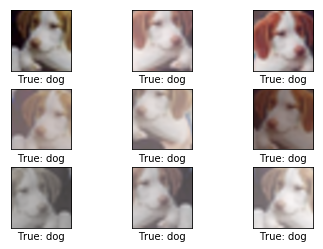

In [56]:
plot_distorted_image(img, cls)

### Realice la optimización

Mi computadora portátil es un Quad-Core con 2 GHz por núcleo. Tiene una GPU pero no es lo suficientemente rápida para TensorFlow, por lo que solo usa la CPU. Se tarda aproximadamente 1 hora en realizar 10.000 iteraciones de optimización utilizando la CPU en esta PC. Para este tutorial realicé 150,000 iteraciones de optimización, por lo que me llevó unas 15 horas. Lo dejé correr durante la noche y en varios puntos durante el día.

Debido a que estamos guardando los puntos de control durante la optimización y porque estamos restaurando el último punto de control cuando reiniciamos el código, podemos detener y continuar la optimización más adelante.

In [57]:
if False:
    optimize(num_iterations=1000)

### Resultados

Después de 150,000 iteraciones de optimización, la precisión de clasificación es aproximadamente del 79-80% en el conjunto de prueba. Ejemplos de mis-clasificaciones se trazan a continuación. Algunos de estos son difíciles de reconocer incluso para los humanos y otros son errores razonables, p. entre un carro grande y un camión, o entre un gato y un perro, mientras que otros errores parecen un poco extraños.

Accuracy on Test-Set: 10.0% (1000 / 10000)
Example errors:


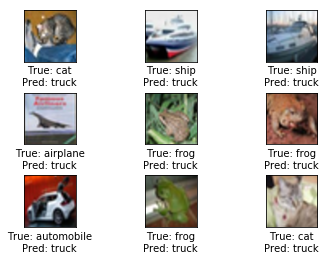

Confusion Matrix:
[  0   0   1   0   0   0   0   0   0 999] (0) airplane
[  0   3   0   0   0   0   0   0   0 997] (1) automobile
[  0   2   0   0   0   0   0   0   0 998] (2) bird
[  0   1   6   0   0   0   0   0   0 993] (3) cat
[  0   3   4   0   0   0   0   0   0 993] (4) deer
[  0   0   1   0   0   0   0   0   0 999] (5) dog
[  0   1   0   0   0   0   0   0   0 999] (6) frog
[  0   3   1   0   0   0   0   0   0 996] (7) horse
[   0    0    0    0    0    0    0    0    0 1000] (8) ship
[  0   1   2   0   0   0   0   0   0 997] (9) truck
 (0) (1) (2) (3) (4) (5) (6) (7) (8) (9)


In [58]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

### Pesos convolucionales

A continuación, se muestran algunos de los pesos (o filtros) para la primera capa convolucional. Hay 3 canales de entrada, por lo que hay 3 de estos conjuntos, que puede trazar al cambiar el input_channel.

Tenga en cuenta que los pesos positivos son rojos y los negativos son azules.

Min:  -0.57979, Max:   0.57014
Mean: 0.00044, Stdev: 0.16344


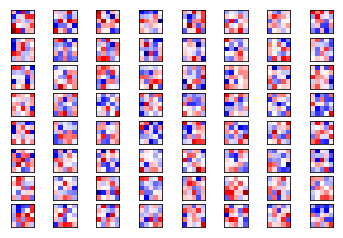

In [59]:
plot_conv_weights(weights=weights_conv1, input_channel=0)

Trace algunos de los pesos (o filtros) para la segunda capa convolucional. Estos son aparentemente más cercanos a cero que los pesos de las primeras capas convolucionales, ver la desviación estándar más baja.

Min:  -0.16842, Max:   0.16237
Mean: -0.00010, Stdev: 0.03525


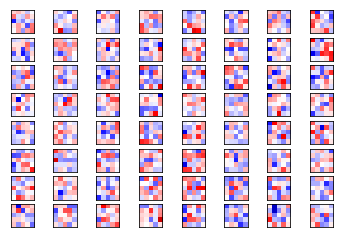

In [60]:
plot_conv_weights(weights=weights_conv2, input_channel=1)

### Output of convolutional layers
Función auxiliar para trazar una imagen.

In [61]:
def plot_image(image):
    # Crear figura con sub-parcelas.
    fig, axes = plt.subplots(1, 2)

    # Referencias a las sub-parcelas.
    ax0 = axes.flat[0]
    ax1 = axes.flat[1]

    # Muestra imágenes en bruto y suavizadas en subtramas.
    ax0.imshow(image, interpolation='nearest')
    ax1.imshow(image, interpolation='spline16')

    # Establecer etiquetas.
    ax0.set_xlabel('Puro')
    ax1.set_xlabel('Suave')
    
    # Asegúrese de que la trama se muestra correctamente con múltiples parcelas
    # en una sola celda de Notebook
    plt.show()

Trace una imagen del conjunto de prueba. La imagen pixelada sin procesar se usa como entrada a la red neuronal.

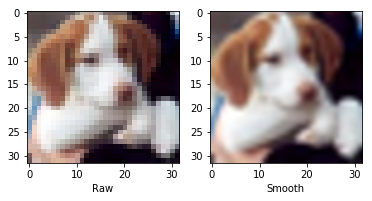

In [62]:
img, cls = get_test_image(16)
plot_image(img)

Utilice la imagen sin procesar como entrada a la red neuronal y trace la salida de la primera capa convolucional.

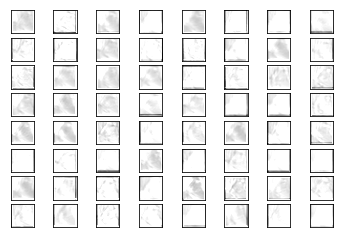

In [63]:
plot_layer_output(output_conv1, image=img)

Usando la misma imagen como entrada a la red neuronal, ahora traza la salida de la segunda capa convolucional.

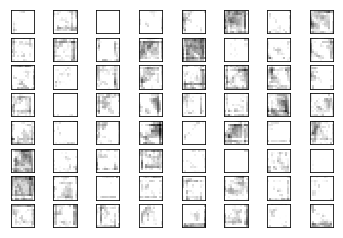

In [64]:
plot_layer_output(output_conv2, image=img)

### Predicted class-labels

Obtenga la clase de etiqueta y el número de clase predichos para esta imagen.

In [65]:
label_pred, cls_pred = session.run([y_pred, y_pred_cls],
                                   feed_dict={x: [img]})

Imprime la etiqueta de clase predicha.

In [66]:
# Establezca las opciones de redondeo para numpy.
np.set_printoptions(precision=3, suppress=True)

# Imprime la etiqueta predicha.
print(label_pred[0])

[ 0.039  0.125  0.124  0.07   0.038  0.064  0.043  0.105  0.032  0.359]


La etiqueta de clase predicho es una matriz de longitud 10, con cada elemento que indica qué tan segura es la red neuronal de que la imagen es la clase dada.

En este caso, el elemento con índice 3 tiene un valor de 0,493, mientras que el elemento con índice 5 tiene un valor de 0,490. Esto significa que la red neuronal cree que la imagen muestra una clase 3 o una clase 5, que es un gato o un perro, respectivamente.

In [67]:
class_names[3]

'cat'

In [68]:
class_names[5]

'dog'

### Cerrar sesión de TensorFlow

Ahora hemos terminado de utilizar TensorFlow, por lo que cerramos la sesión para liberar sus recursos.

In [69]:
# Esto se ha comentado en caso de que quiera modificar y experimentar
# con el portátil sin tener que reiniciarlo.
# session.close()

### Conclusión

Este tutorial mostró cómo hacer una red neuronal convolucional para clasificar imágenes en el conjunto de datos CIFAR-10. La precisión de la clasificación fue de aproximadamente 79-80% en el conjunto de prueba.

La salida de las capas convolucionales también se trazó, pero era difícil ver cómo la red neuronal reconoce y clasifica las imágenes de entrada. Se necesitan mejores técnicas de visualización.

### Ejercicios

Estas son algunas sugerencias de ejercicios que pueden ayudarlo a mejorar sus habilidades con TensorFlow. Es importante obtener experiencia práctica con TensorFlow para aprender cómo usarlo correctamente.

You may want to backup this Notebook before making any changes.

* Ejecute la optimización de 10.000 iteraciones y vea cuál es la precisión de clasificación. Esto creará un punto de control que guarda todas las variables del gráfico TensorFlow.
* Continue running the optimization for another 100,000 iterations and see if the classification accuracy has improved. Then try another 100,000 iterations. Does the accuracy improve and do you think it is worth the extra computational time?
* Try changing the image distortions in the pre-processing.
* Intenta cambiar la estructura de la red neuronal. Puedes intentar hacer que la red neuronal sea más pequeña o más grande. ¿Cómo afecta el tiempo de entrenamiento y la precisión de clasificación? Tenga en cuenta que los puntos de control no se pueden volver a cargar cuando se cambia la estructura de la red neuronal.
* Intente utilizar la normalización por lotes para la segunda capa convolucional también. También intente eliminarlo de ambas capas.
* Investigue algunas de las mejores redes neuronales para CIFAR-10 y trate de implementarlas.
* Explique a un amigo cómo funciona el programa.

### Licencia (MIT)
Copyright (c) 2017 by <a>Vitmar J Aliaga Cruz</a>

Se concede permiso, de forma gratuita, a cualquier persona que obtenga una copia de este software y los archivos de documentación asociados (el "Software"). tratar el Software sin restricciones, incluidos, entre otros, los derechos de uso, copia, modificación, fusión, publicación, distribución, sublicencia y / o venta de copias del Software, y para permitir a las personas a quienes se les proporciona el Software hacerlo, sujeto a las siguientes condiciones:

El aviso de copyright anterior y este aviso de permiso se incluirán en todas las copias o porciones sustanciales del Software.

EL SOFTWARE SE PROPORCIONA "TAL CUAL", SIN GARANTÍA DE NINGÚN TIPO, EXPRESA O IMPLÍCITA, INCLUIDAS, ENTRE OTRAS, LAS GARANTÍAS DE COMERCIABILIDAD, IDONEIDAD PARA UN PROPÓSITO EN PARTICULAR Y NO INFRACCIÓN. EN NINGÚN CASO LOS AUTORES O PROPIETARIOS DE DERECHOS DE AUTOR SERÁN RESPONSABLES DE NINGUNA RECLAMACIÓN, DAÑOS U OTRA RESPONSABILIDAD, YA SEA EN UNA ACCIÓN DE CONTRATO, AGRAVIO O DE OTRA ÍNDOLE, DERIVADO DE, FUERA DEL USO DEL SOFTWARE O EN RELACIÓN CON ÉL O EL USO U OTRAS DISPOSICIONES DEL SOFTWARE.